# DCGAN For Novel Pokemon Generation
Development of a Deep Convolutional Generative Adversarial Network for generating novel 64x64 Pokemon images.
Code is largely adapted from the PyTorch DCGAN Tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


Dataset: https://www.kaggle.com/kvpratama/pokemon-images-dataset#



Project by Jack Foster

In [37]:
import PIL as pil
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [38]:
# Comment out if not using Google Collab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
root_path = 'gdrive/My Drive/Pokemon Project/'
#Set random seeds
manual_seed = 555
random.seed(manual_seed)
torch.manual_seed(manual_seed)

#Root directory for data
dataroot = "imgs"

In [40]:
#Threads for dataloader
workers = 2

#Batchsize during training
batch_size = 2 #128

In [41]:
#Spatial size of training images.
image_size = 64

#Number of channels in the training image -- 1 for greyscale, 3 for RGB
num_channels = 3

#Size of generator input vector
gen_input_size = 100

#Size of feature maps in generator
gen_features = 64

#Size of feature maps in discriminator
disc_features = 64

#Number of training epochs
num_epochs = 80 #5

#Learning rate for optimizers, value defined in the paper
lr = 0.0002

#Beta1 - Momentum hyper parameter, value defined in the paper
mom = 0.5

#Number of GPUs to use
num_gpus = 1

In [42]:
#Create the dataset #TODO look at why this works
dataset = dset.ImageFolder(root=root_path+dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                            ])
                            )
#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                        shuffle=True, num_workers=workers)
#Check if we have GPUs, else use CPUs
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpus >0) else "cpu")

In [43]:
# Plot some training images
"""real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
"""

def init_weights(model):
    """
    Args:
        |model initialised model
    Func:
        |Initialise weights of model randomly 
            from ~N(0,0.02) as indicated in the paper
        |Reinitialise all conv, conv-trans and
            batch-normalisation layers to meet this
    """
    #Get model class
    model_class = model.__class__.__name__ 
    if model_class.find('Conv') != -1:
        #if passed model is convolutional
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif model_class.find('BatchNorm') != -1:
        #if passed model is batchnorm
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data,0)

In [44]:
class Generator(nn.Module):
    """
    Generator class
        |Takes random uniform noise as input and 
            maps this to data space. In other words it
            creates a new image akin to the training set
            based upon the random noise
        |This is accomplishe through a series of 2D 
            convolutional transpose layers, each paired
            with a 2D batch norm layer and relu activation.
            The batch norm layers a CORE, they allow for
            the flow of gradients during training.
        |The output of the generator is fed through a tanh
            function to return it to range |-1,1|
    """
    def __init__(self,ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Input goes into convolution layer
            nn.ConvTranspose2d(gen_input_size, gen_features*8,4,1,0),
            nn.BatchNorm2d(gen_features*8),
            nn.ReLU(True),
            #Next Conv Layer, state size (features*8)*4*4
            nn.ConvTranspose2d(gen_features*8, gen_features*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features*4),
            nn.ReLU(True),
            #Next Conv Layer, state size (features*4)*8*8
            nn.ConvTranspose2d(gen_features*4, gen_features*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features*2),
            nn.ReLU(True),
            #Next Conv Layer, state size (features*2)*16*16
            nn.ConvTranspose2d(gen_features*2, gen_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            #Final Conv Layer, state size (features)*32*32
            nn.ConvTranspose2d(gen_features, num_channels, 4, 2, 1, bias=False),
            nn.Tanh(),
            #state size now num_channels x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [45]:
#Create Generator
gen_net = Generator(num_gpus).to(device)

#Handle multi-GPU code, if necessary
if(device.type=='cuda') and (num_gpus > 1):
    gen_net = nn.DataParallel(gen_net, list(range(num_gpus))) 

#Initialise all weights randomly, ~N(0.0, 0.2)
#applies to all children of gen_net
gen_net.apply(init_weights)
print(gen_net)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [46]:
class Discriminator(nn.Module):
    """
        |Binary classification network.
        |Takes an image as input
        |Outputs a scalar probability that the input image is real
        |Passes the input image through a series of Conv2D,
            BatchNorm2d and LeakyReLU layers.
        |Outputs the final probability through a sigmoid activation function
            to keep it between |0,1|
        |Good to use Strided Convolution->BatchNorm->LeakyReLUs
            instead of pooling for downsampling as the network can
            learn its own pooling function.
        |Batchnorm->LeakyReLU promote healthy gradient flow which is 
            critical for learning process of both networks
    """
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        #Boris
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Input is num_channel*64*64
            nn.Conv2d(num_channels,disc_features,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            #Pass to conv layer, features*32*32
            nn.Conv2d(disc_features, disc_features*2,4,2,1,bias=False),
            nn.BatchNorm2d(disc_features*2),
            nn.LeakyReLU(0.2,inplace=True),
            #pass to conv layer, (features*2)*16*16
            nn.Conv2d(disc_features*2, disc_features*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features*4),
            nn.LeakyReLU(0.2, inplace=True),
            #pass to conv layer, (features*4)*8*8
            nn.Conv2d(disc_features*4, disc_features*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features*8),
            nn.LeakyReLU(0.2, inplace=True),
            #Final layer, (features*8)*4*4
            nn.Conv2d(disc_features*8,1,4,1,0,bias=False),
            nn.Sigmoid(),
        )

    def forward(self,input):
        return self.main(input)

In [52]:
def run():
    #Create the Discriminator
    disc_net = Discriminator(num_gpus).to(device)

    #Handle multi-gpu
    if(device.type=='cuda') and (num_gpus > 1):
        disc_net = nn.DataParallel(disc_net,list(range(num_gpus)))

    #Randomly initialise weights, sampled from ~N(0, 0.2)
    disc_net.apply(init_weights)

    print(disc_net)

    """
    BCELoss function is a mixture of a Sigmoid activation
    cross-entropy loss. Basically its a log-loss function
    for probability functions p(x)=|0,1|,
    Basically just punishes very poor results much more than
    slightly wrong results.
    Adam is an alternative to SGD, however it maintains a 
    per-parameter learning rate, and adapts to the magnitude 
    of the recent movements through the gradient
    """

    #Initialise BCELoss function
    criterion = nn.BCELoss()

    #Create batch of random noise 
    fixed_noise = torch.randn(64,gen_input_size,1,1,device=device)

    # Establish convention for real and fake labels during training
    real_label = 1
    fake_label = 0

    #Setup Adam optimisers for both G and D
    optimse_d = optim.Adam(disc_net.parameters(), lr=lr, betas=(mom, 0.999))
    optimse_g = optim.Adam(gen_net.parameters(), lr=lr, betas=(mom, 0.999))

    #Training
    """
    Training:
        |Discriminator:
            |maximise the probability of correctly classifying a given input
            |as real or fake. We wish to do gradient ascent.
            |First, construct a batch of real samples from te training set, and do
            |a forward pass through the network, calculating the loss.
            |Do the same with fake samples, calculating the loss.
            |Only then do a backwards pass through the network to get the gradients.
            |Now with the accumulated, do a step of the Optimiser.

        |Generator:
            |Minimise log(1-D(G(z))), i.e. make the disc think that G(z) is real.
            |This doesn't provide strong enough gradients, so we seek to maximise log(D(G(z)))
            |This is accomplished by:
                |classifying the generator output from part 1 with the discriminator, computing G's loss
                |using *real* labels as the target, computing G's gradients in a backwards pass and finally
                |updating G's parameters with an optimizer step.
    """
    #lists for progress tracking
    #g_losses = []
    #d_losses = []
    iters=0

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            img_list = []
            ###Discriminator training###
            ##Train with Real Batch
            #Zero out the gradients, as they're accumulated
            disc_net.zero_grad()
            #Format data batch, put it on the device
            real_dat_dev = data[0].to(device)
            #batch size 
            b_size = real_dat_dev.size(0)
            #training labels are a tensor of b_size full of real_label.
            label = torch.full((b_size,), real_label, device=device)
            #Forward pass, silently calls nn.forward(), view(-1) means the dimension is inferred
            disc_output = disc_net(real_dat_dev).view(-1)
            #Calculate loss on real-batch using the nn.BCELoss function defined earlier
            disc_err_real = criterion(disc_output, label.to(torch.float32))
            #backward pass to get gradients
            disc_err_real.backward(retain_graph=True)
            #get the mean output as a scalar, not a tensor
            #disc_x = disc_output.mean().item
            
            ##Train with fake batch
            #Generate noise
            noise = torch.randn(b_size, gen_input_size, 1, 1, device=device)
            #generate fake image batch with generator net
            fake = gen_net(noise)
            label.fill_(fake_label)
            #Classify all fake batch data with disc
            disc_output = disc_net(fake).view(-1)
            #Calculate gradients for this batch
            disc_err_fake = criterion(disc_output, label.to(torch.float32))
            disc_err_fake.backward(retain_graph=True)
            #disc_gen_x = disc_output.mean().item()
            disc_error = disc_err_fake + disc_err_real
            #Finally, update discriminator using Adam
            optimse_d.step()
            ###Train Generator###
            #Zero gradient, as it accumulates
            gen_net.zero_grad()
            #targets
            label.fill_(real_label)
            #As disc was just updated, perform another forward pass
            disc_output = disc_net(fake).view(-1)
            #Calculate Generator loss based on the result
            gen_error = criterion(disc_output,label.to(torch.float32))
            gen_error.backward(retain_graph=True)
            #disc_gen_x2 = disc_output.mean().item()
            #update generator
            optimse_g.step()

            #output training stats
            if (i%50==0):
                print("######################################################################\n" +
                "Epoch: " + str(epoch) + "\nIter: "+ str(i) + "/"+ str(len(dataloader)) + "\nDisc Error: " + str(disc_error.item()) + "\nGen Error: " + str(gen_error.item()))
            
            #Save losses for plotting later
            #g_losses.append(gen_error.item())
            #d_losses.append(disc_error.item())

            #Finally check how we're doing by using fixed noise
            if(iters % 500 == 0) or ((epoch == num_epochs-1) and i==len(dataloader)-1):
                #no grad as its just testing.
                with torch.no_grad():
                    fake = gen_net(fixed_noise).detach().cpu()
                #list of images that were made!
                img_list.append(vutils.make_grid(fake,padding=2, normalize=True))

        if epoch % 20 == 0:
            #Plot graphs and show images
            #plt.figure(figsize=(10,5))
            #plt.title("Generator and Discriminator Loss During Training")
            #plt.plot(g_losses, label="G")
            #plt.plot(d_losses, label="D")
            #plt.xlabel("Iterations")
            #plt.ylabel("Loss")
            #plt.legend()
            #plt.show()
            fig = plt.figure(figsize=(15,15))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.show()

    torch.save(gen_net, "pokemon_generator_network")
    torch.save(disc_net, "pokemon_discriminator_network")
    fig = plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
##############################

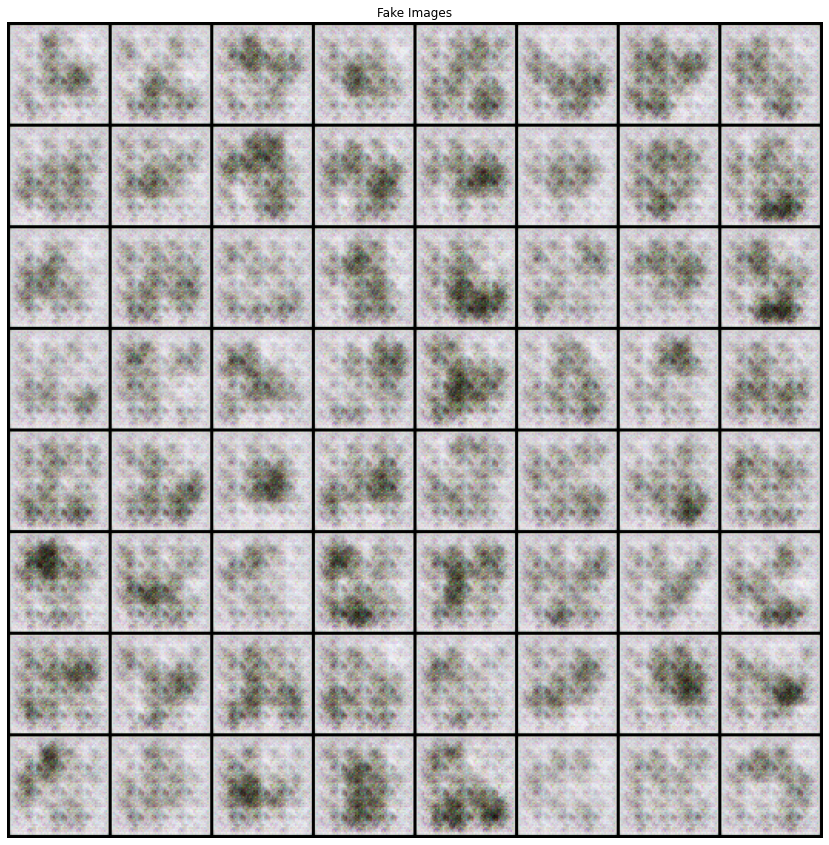

######################################################################
Epoch: 1
Iter: 0/410
Disc Error: 0.2568953037261963
Gen Error: 6.844805717468262
######################################################################
Epoch: 1
Iter: 50/410
Disc Error: 1.0079454183578491
Gen Error: 8.930388450622559
######################################################################
Epoch: 1
Iter: 100/410
Disc Error: 0.37080976366996765
Gen Error: 3.7322030067443848
######################################################################
Epoch: 1
Iter: 150/410
Disc Error: 2.1738407611846924
Gen Error: 5.884941101074219
######################################################################
Epoch: 1
Iter: 200/410
Disc Error: 0.3260212540626526
Gen Error: 7.703658103942871
######################################################################
Epoch: 1
Iter: 250/410
Disc Error: 3.2160661220550537
Gen Error: 2.341613292694092
######################################################################
Epoch:

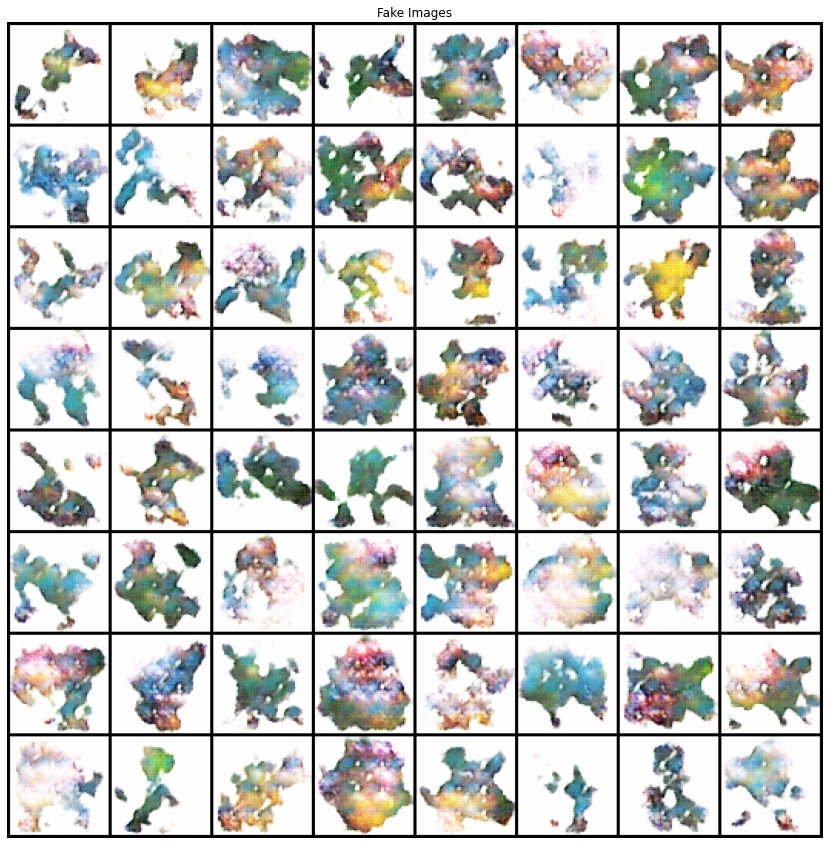

######################################################################
Epoch: 21
Iter: 0/410
Disc Error: 0.5506992936134338
Gen Error: 3.398135185241699
######################################################################
Epoch: 21
Iter: 50/410
Disc Error: 1.0650079250335693
Gen Error: 2.354050397872925
######################################################################
Epoch: 21
Iter: 100/410
Disc Error: 0.24216966331005096
Gen Error: 2.5803959369659424
######################################################################
Epoch: 21
Iter: 150/410
Disc Error: 1.1232709884643555
Gen Error: 3.996349811553955
######################################################################
Epoch: 21
Iter: 200/410
Disc Error: 0.7529423236846924
Gen Error: 3.0056777000427246
######################################################################
Epoch: 21
Iter: 250/410
Disc Error: 0.07002478837966919
Gen Error: 3.4666686058044434
####################################################################

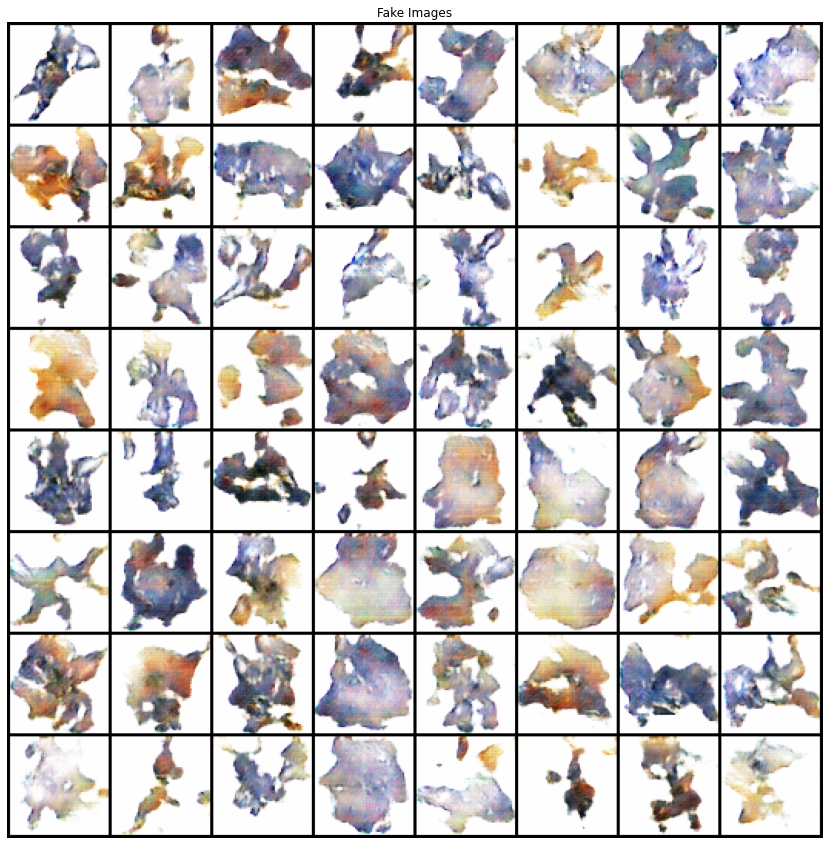

######################################################################
Epoch: 41
Iter: 0/410
Disc Error: 0.8985345363616943
Gen Error: 4.452451229095459
######################################################################
Epoch: 41
Iter: 50/410
Disc Error: 0.09763671457767487
Gen Error: 3.4617090225219727
######################################################################
Epoch: 41
Iter: 100/410
Disc Error: 0.5006579756736755
Gen Error: 4.718085765838623
######################################################################
Epoch: 41
Iter: 150/410
Disc Error: 0.5878628492355347
Gen Error: 2.033458948135376
######################################################################
Epoch: 41
Iter: 200/410
Disc Error: 0.12994886934757233
Gen Error: 3.1125683784484863
######################################################################
Epoch: 41
Iter: 250/410
Disc Error: 0.25892430543899536
Gen Error: 2.827005386352539
####################################################################

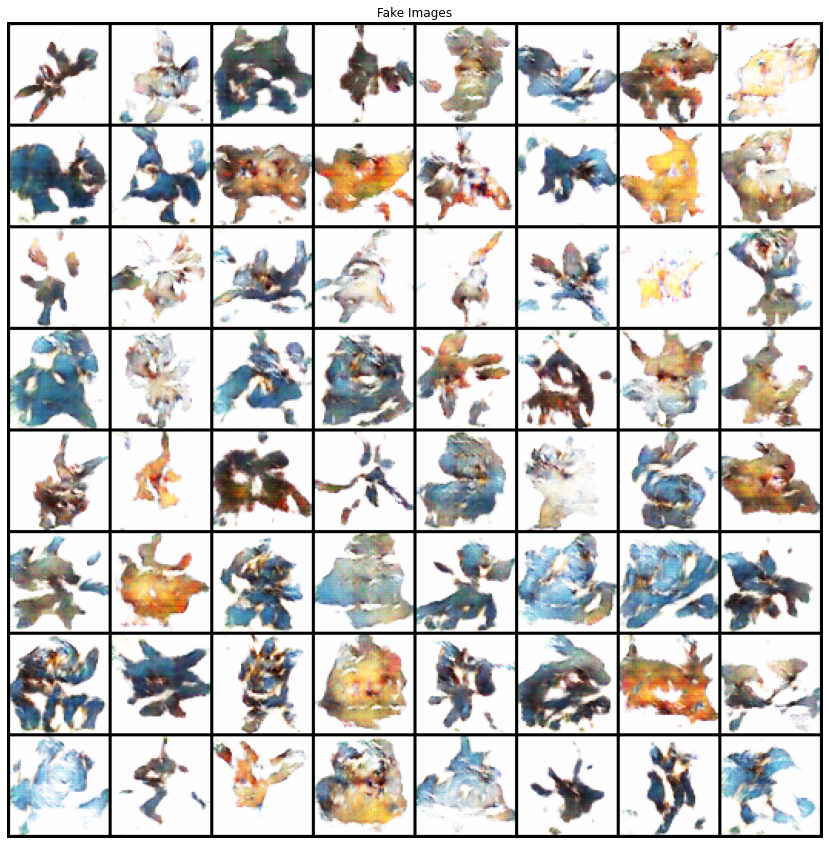

######################################################################
Epoch: 61
Iter: 0/410
Disc Error: 0.3104638457298279
Gen Error: 4.607182502746582
######################################################################
Epoch: 61
Iter: 50/410
Disc Error: 0.00348700606264174
Gen Error: 5.566819190979004
######################################################################
Epoch: 61
Iter: 100/410
Disc Error: 1.227743148803711
Gen Error: 3.739004611968994
######################################################################
Epoch: 61
Iter: 150/410
Disc Error: 0.10505881905555725
Gen Error: 4.5122222900390625
######################################################################
Epoch: 61
Iter: 200/410
Disc Error: 1.668269395828247
Gen Error: 9.014399528503418
######################################################################
Epoch: 61
Iter: 250/410
Disc Error: 0.014601217582821846
Gen Error: 5.309451580047607
######################################################################

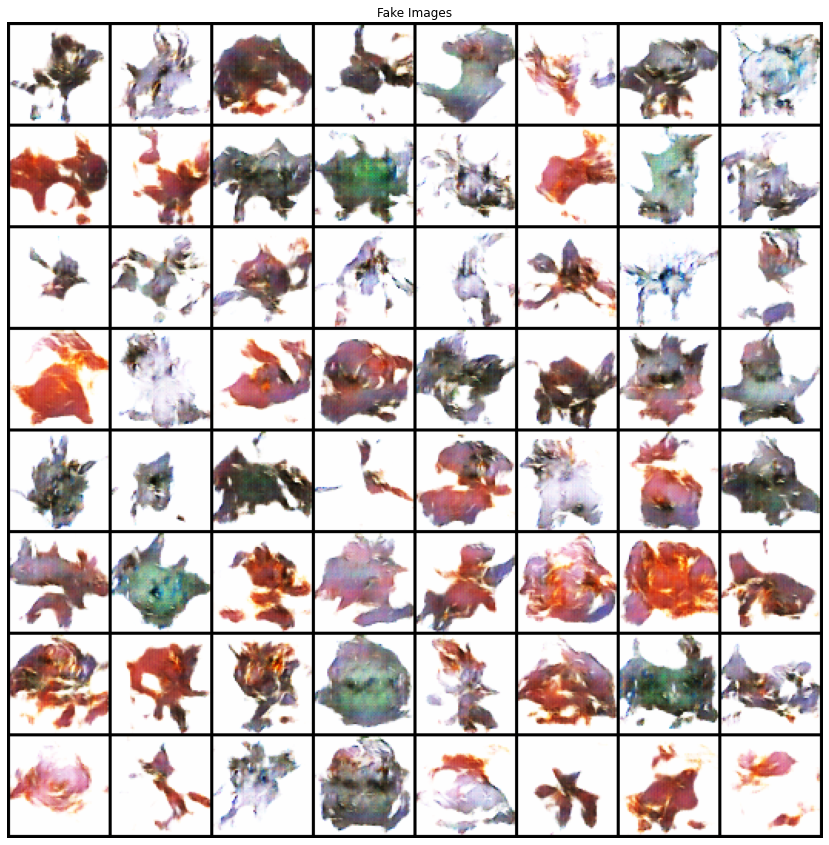

In [53]:
run()